# FinanceInfo

In [1]:
!pip3 install --user pandas
!pip3 install --user html5lib
!pip3 install --user BeautifulSoup4
!pip3 install --user plotly
!pip3 install --user nbformat

In [59]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs

import datetime
from mplfinance.original_flavor import candlestick2_ohlc
import matplotlib.pyplot as plt

In [3]:
headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36'}

def get_url(item_name, code_df): 
  code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False) 
  url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code) 
  print("요청 URL = {}".format(url)) 
  return url

def get_html_table_symbol(url):
  response = requests.get(url, headers=headers)
  html = bs(response.text, 'lxml')
  html_table = html.select('table')
  len(html_table)
  return str(html_table)

In [4]:
def get_report_time():
  return datetime.datetime.now().strftime("%Y%m%d")

In [5]:
def get_stochastic(df, n=15, m=5, t=3):
  df = pd.DataFrame(df)
  ndays_high = df.high.rolling(window=n, min_periods=1).max()
  ndays_low = df.low.rolling(window=n, min_periods=1).min()

  # Fast%K
  kdj_k = ((df.close - ndays_low)/(ndays_high-ndays_low))*100 #n=15
  # Fast%D
  kdj_d = kdj_k.ewm(span=m).mean() #m=5
  # Slow%D
  kdj_j = kdj_d.ewm(span=t).mean() #t=3
  
  df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
  return df

In [47]:
class FinanceInfo:
  def __init__(self, item_name, page:10):
    self.item_name = item_name
    self.page = page
  
    # 1: Get event_code from 상장법인목록.xls
    code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
    code_df.종목코드 = code_df.종목코드.map('{:06d}'.format) 
    code_df = code_df[['회사명', '종목코드']]
    code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})

    # 2. Get stock data from naver finance
    url = get_url(self.item_name, code_df)

    df = pd.DataFrame()
    for _page in range(1, self.page):
      pg_url = '{url}&page={page}'.format(url=url, page=_page)
      table = get_html_table_symbol(pg_url)
      df = df.append(pd.read_html(table, header=0)[0], ignore_index=True)
    df = df.dropna()

    # 3. Rename columns
    df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
    df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 
    df['date'] = pd.to_datetime(df['date']) 
    df = df.sort_values(by=['date'], ascending=True)

    self.df = df

  def whoami(self):
    return self.item_name

  def get_page(self):
    return self.page

  def get_df(self):
    return self.df

  def get_stochastic(self):
    df = get_stochastic(self.df)

    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(5,1,1)
    ax2 = fig.add_subplot(5,1,2)
    ax3 = fig.add_subplot(5,1,3)
    ax4 = fig.add_subplot(5,1,4)
    ax5 = fig.add_subplot(5,1,5)

    ax4.plot(df.date, df['kdj_j'], 'r',label='Slow%D')
    ax3.plot(df.date, df['kdj_d'], 'g',label='Slow%K')
    ax2.plot(df.date, df['kdj_k'], 'b',label='Fast%K')

    ax5.plot (df.date, df['kdj_d'], 'g',label='Fast%D (Slow%K)')
    ax5.plot(df.date, df['kdj_j'] , 'r',label='Slow%D')

    candlestick2_ohlc(ax1, df['open'],df['high'],df['low'], df['close'], width=0.5, colorup='r', colordown='b')

    ax4.legend()
    ax3.legend()
    ax2.legend()

    plt.axhline(20)
    plt.axhline(80)

    plt.savefig('../report/%s-%s.pdf'%(self.item_name,get_report_time()))
    plt.close(fig)
    #return fig

In [48]:
if __name__ == '__main__':
  item = FinanceInfo('KG ETS',page=10)
  item.get_stochastic()

요청 URL = http://finance.naver.com/item/sise_day.nhn?code=151860


# Stock Signals
http://www.stocksignals.co.kr:8080/stockguest/0025.php

In [200]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

code_df = pd.read_html('http://www.stocksignals.co.kr:8080/stockguest/0025.php', header=0)[8]
print(code_df)

url = 'http://www.stocksignals.co.kr:8080/stockguest/0025.php'

webpage = requests.get(url)
soup = BeautifulSoup(webpage.content, "html.parser")

html_ = str(soup.findAll("td", {"colspan":"11"}))
df = pd.read_html(html_)[1]
headers = df.iloc[0]
headers2 = df.iloc[1]

df = pd.DataFrame(df.values[2:], columns=headers)
df.columns = pd.MultiIndex.from_tuples(zip(headers2,df.columns))

pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

URLError: <urlopen error [Errno 113] No route to host>

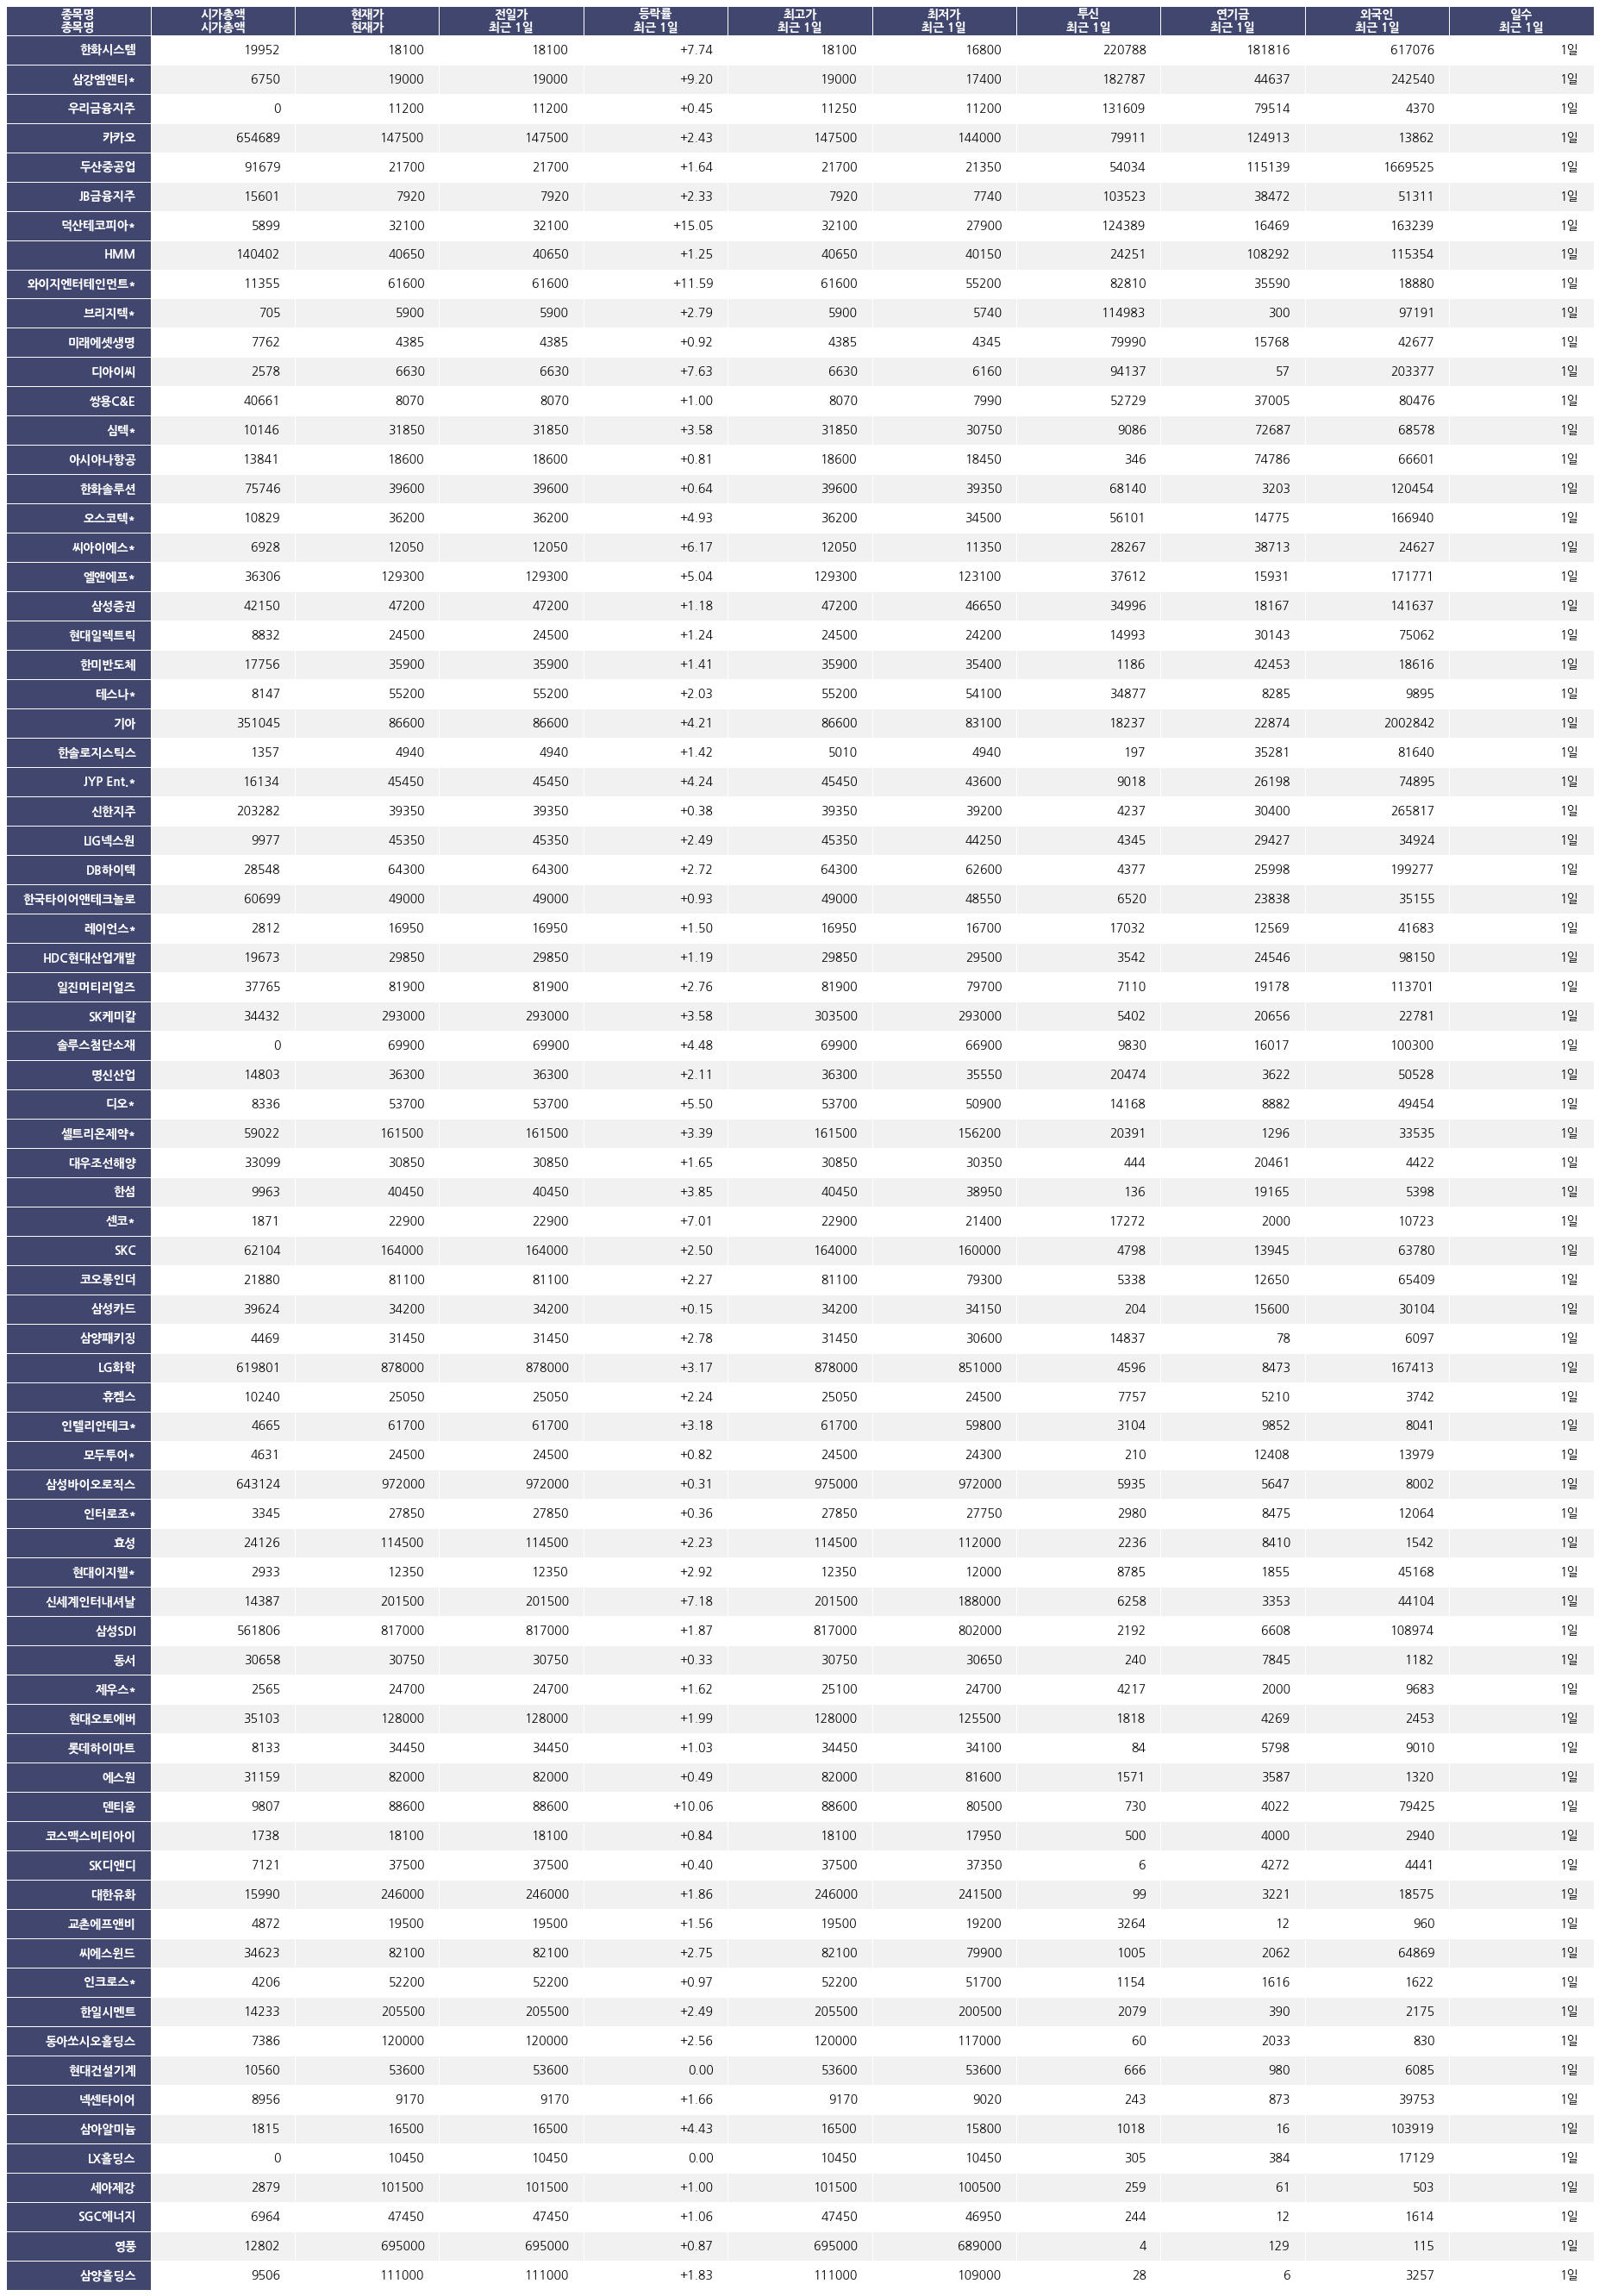

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
  if ax is None:
    size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
    fig, ax = plt.subplots(figsize=size)
    ax.axis('off')

  col = []
  for i in range(len(data.columns)):
    col.append((data.columns[i][0] + '\n' + data.columns[i][1]))

  mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=col, **kwargs)

  mpl_table.auto_set_font_size(False)
  mpl_table.set_fontsize(font_size)

  for k, cell in  six.iteritems(mpl_table._cells):
    cell.set_edgecolor(edge_color)
    if k[0] == 0 or k[1] < header_columns:
      cell.set_text_props(weight='bold', color='w')
      cell.set_facecolor(header_color)
    else:
      cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
  return ax

render_mpl_table(df, header_columns=1, col_width=3.0)

def get_report_time():
  return datetime.datetime.now().strftime("%Y%m%d")

plt.savefig('../report/%s-%s.png'%('investment-fund', get_report_time()))
#plt.close()